In [1]:
import pandas as pd
import requests as rq
import time
import json
from langchain_ollama import OllamaLLM
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from transformers import pipeline


import logging

logging.getLogger("transformers").setLevel(logging.ERROR)


In [2]:
llm = OllamaLLM(model="llama3:8b")

In [ ]:
def get_ollama_response(text):
    prompt = f"""Please analyse the following text and
    give response only in json format and no other extra text as {{"score":<SCORE>, "justification":<JUST>"}}, 
    here <SCORE> is sentiment score between -1 to 1 (where -1 is most negative, 0 is neutral and 1 is most positive)
    and <JUST> is Justification for why you choose this sentiment score
    Text: {text}"""

    try:
        response_text = llm.invoke(prompt)

        # print(response_text)

        # lines  = response_text.strip().split('\n')

        # score = float(lines[0])

        # justification = lines[1] if len(lines)>1 else "No justification provided"

        # score = max(min(score, 1.0), -1.0)

        return json.loads(response_text)

        # return {
        #     "score": score,
        #     "justification": justification
        # }

    except Exception as e:
        print(f"Error in processing: {str(e)}")
        return {
            "score": -2.0,
            "justification": f"Error in processing: {str(e)}"
        }



In [10]:
sentences = [
    "The product is decent, but it could be improved.",
    "The app has a nice interface, though it lags occasionally.",
    "Customer service was helpful, but the response time was long.",
    "The book was informative, though some parts felt repetitive.",
    "The new update introduced useful features, but a few bugs remain.",
    "The restaurant had a cozy atmosphere, but the food was just average.",
    "Shipping was quick, though the packaging was slightly damaged.",
    "The laptop runs well for basic tasks, but struggles with heavy applications.",
    "The event was well-organized, although some sessions were dull.",
    "The phone’s battery life is great, but the camera could be better.",
    "The coffee shop has a great vibe, but the drinks are overpriced.",
    "The headphones are comfortable, though the bass is a bit weak.",
    "The online course was well-structured, but lacked practical examples.",
    "The smartwatch looks stylish, but the battery drains quickly.",
    "The hotel was clean, but the staff seemed indifferent.",
    "The product exceeded my expectations, fantastic quality!",
    "The app keeps crashing, making it unusable and frustrating.",
    "The package arrived on time as expected.",
    "I love the new update, it makes everything so much smoother.",
    "Terrible service, I waited over an hour and still no response.",
    "This phone has a 6.5-inch screen and a 5000mAh battery.",
    "Great customer service, they resolved my issue quickly and politely.",
    "The quality of the product is disappointing, not worth the price.",
    "The book has 300 pages and covers various topics.",
    "The movie was an absolute masterpiece, I enjoyed every moment.",
    "This was the worst meal I’ve ever had, completely inedible.",
    "The event started at 5 PM and ended at 8 PM.",
    "This book changed my perspective on life, highly recommend it!",
    "I regret buying this item, it broke within a week.",
    "The software update introduced several new features."
]

In [12]:
for text in sentences:
    print(get_ollama_response(text=text))

{'score': 0.4, 'justification': "The text starts with a slightly positive statement ('The product is decent'), which indicates a neutral-to-positive tone. However, the subsequent phrase ('but it could be improved') slightly shifts the tone towards neutrality or mild negativity, resulting in a sentiment score of 0.4."}
{'score': 0.4, 'justification': "The text mentions a 'nice' interface, which suggests a positive tone, but also mentions that the app 'lags occasionally', which is a negative point. This mixed sentiment results in a score of 0.4, leaning slightly towards positivity due to the positive description of the interface."}
{'score': 0.4, 'justification': "The text mentions that customer service was 'helpful', which has a positive connotation, but also notes that the response time was 'long' which is slightly negative. The overall sentiment is neutral-to-positive because the helpfulness of the service outweighs the negativity of the slow response time."}
{'score': 0.6, 'justifica

In [89]:
# def process_sentiment_analysis( model="llama_3_8b"):
#     df[f"sentiment_score_{model}"] = 0.0
#     df[f"sentiment_justification"] = ''
#     total_rows = len(df)

#     for idx, row in df.iterrows():
#         try:
#             result = get_ollama_response(row['text'])


#             df.at[idx, f"sentiment_score_{model}"] = result['score']
#             df.at[idx, f"sentiment_justification"] = result['justification']

#             time.sleep(0.5)

#             print(f"Processed {idx+1}/{total_rows} rows ({((idx+1)/total_rows * 100):.2f}%)")

#         except Exception as e:
#             print(f"Error processing row {idx}: {str(e)}")
#             continue


            
    

In [10]:
try:
    output_file= "data/Sentiment_analysis_Data_fin_result.csv"

    # process_sentiment_analysis()
finally:
    # df.to_csv(output_file, index=False)
    print(f"Analysis complete. Result saved to {output_file}")

Analysis complete. Result saved to data/Sentiment_analysis_Data_fin_result.csv


In [58]:
def calculate_SA_Polarity(text,model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"):
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name, force_download=False)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, force_download=False)
        inputs = tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            # print(f"Outputs: {outputs}")
            logits = outputs.logits.squeeze()
            # print(f"Logits: {logits}")

        
        probs = F.softmax(logits, dim=0)
        # print(f"Probs: {probs}")

        # Compute polarity score: (-1 * neg) + (0 * neutral) + (1 * pos)
        polarity = -probs[0] + probs[2]
        
        return polarity
    except Exception as e:
        print(str(e))
        return -2.5

In [90]:
input_file ="data/Sentiment_analysis_Data_fin_result.csv"
df = pd.read_csv(input_file)
df.columns

Index(['text', 'sentiment_score', 'sentiment_score_llama_3_8b',
       'sentiment_justification',
       'sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest',
       'sentiment_score_finiteautomata/bertweet-base-sentiment-analysis',
       'sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'],
      dtype='object')

In [85]:
def process_sentiment_analysis_comp( model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"):
    df[f"sentiment_score_{model}"] = 0.0
    total_rows = len(df)

    for idx, row in df.iterrows():
        try:
            input = row['text']
            result = calculate_SA_Polarity(input)
            print(f"Polarity of {input}: {result}")

            df.at[idx, f"sentiment_score_{model}"] = round(float(result), 2)


            print(f"Processed {idx+1}/{total_rows} rows ({((idx+1)/total_rows * 100):.2f}%)")

        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            continue

In [ ]:

try:
    output_file= "data/Sentiment_analysis_Data_fin_result.csv"
    

    # process_sentiment_analysis_comp()
finally:
    # df.to_csv(output_file, index=False)
    print(f"Analysis complete. Result saved to {output_file}")

Analysis complete. Result saved to data/Sentiment_analysis_Data_fin_result.csv


In [87]:
df.columns

Index(['text', 'sentiment_score', 'sentiment_score_llama_3_8b',
       'sentiment_justification',
       'sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest',
       'sentiment_score_finiteautomata/bertweet-base-sentiment-analysis',
       'sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'],
      dtype='object')

In [13]:
input_file ="data/Sentiment_analysis_Data_fin_result.csv"
df = pd.read_csv(input_file)
df.columns

Index(['text', 'sentiment_score', 'sentiment_score_llama_3_8b',
       'sentiment_justification',
       'sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest',
       'sentiment_score_finiteautomata/bertweet-base-sentiment-analysis',
       'sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'],
      dtype='object')

In [14]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [18]:
models = [
    'sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest',
    'sentiment_score_finiteautomata/bertweet-base-sentiment-analysis',
    'sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
]
compare_with = 'sentiment_score_llama_3_8b'
for name in models:
    mse = mean_squared_error(df[compare_with], df[name])
    mae = mean_absolute_error(df[compare_with],  df[name])
    rmse = math.sqrt(mse)
    print(f"{name} MSE: {mse:.4f}")
    print(f"{name} MAE: {mae:.4f}")
    print(f"{name} RMSE: {rmse:.4f}")

sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest MSE: 0.1006
sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest MAE: 0.2265
sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest RMSE: 0.3172
sentiment_score_finiteautomata/bertweet-base-sentiment-analysis MSE: 0.1006
sentiment_score_finiteautomata/bertweet-base-sentiment-analysis MAE: 0.2265
sentiment_score_finiteautomata/bertweet-base-sentiment-analysis RMSE: 0.3172
sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis MSE: 0.1006
sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis MAE: 0.2265
sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis RMSE: 0.3172


In [19]:
import matplotlib.pyplot as plt

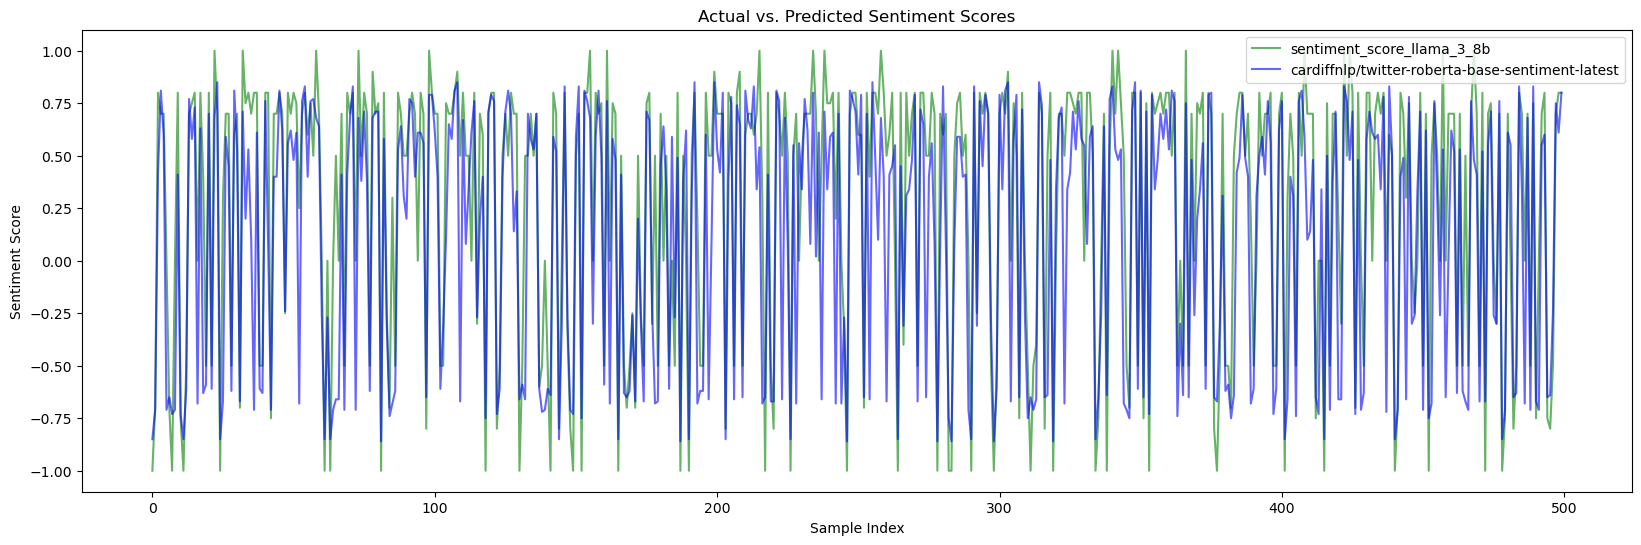

In [20]:
plt.figure(figsize=(20, 6))

# plt.plot(df.head(500)['sentiment_score_llama_3_8b'], color='black', label='Actual', alpha=0.6)
# plt.plot(df.head(500)['sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest'], color='blue', label='cardiffnlp/twitter-roberta-base-sentiment-latest', alpha=0.6)

plt.plot(df.head(500)['sentiment_score_llama_3_8b'], color='green', label='sentiment_score_llama_3_8b', alpha=0.6)

plt.plot(df.head(500)['sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest'], color='blue', label='cardiffnlp/twitter-roberta-base-sentiment-latest', alpha=0.6)

# plt.plot((df.head(500)['sentiment_score_llama_3_8b']-df.head(500)['sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis']), color='red', label='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()

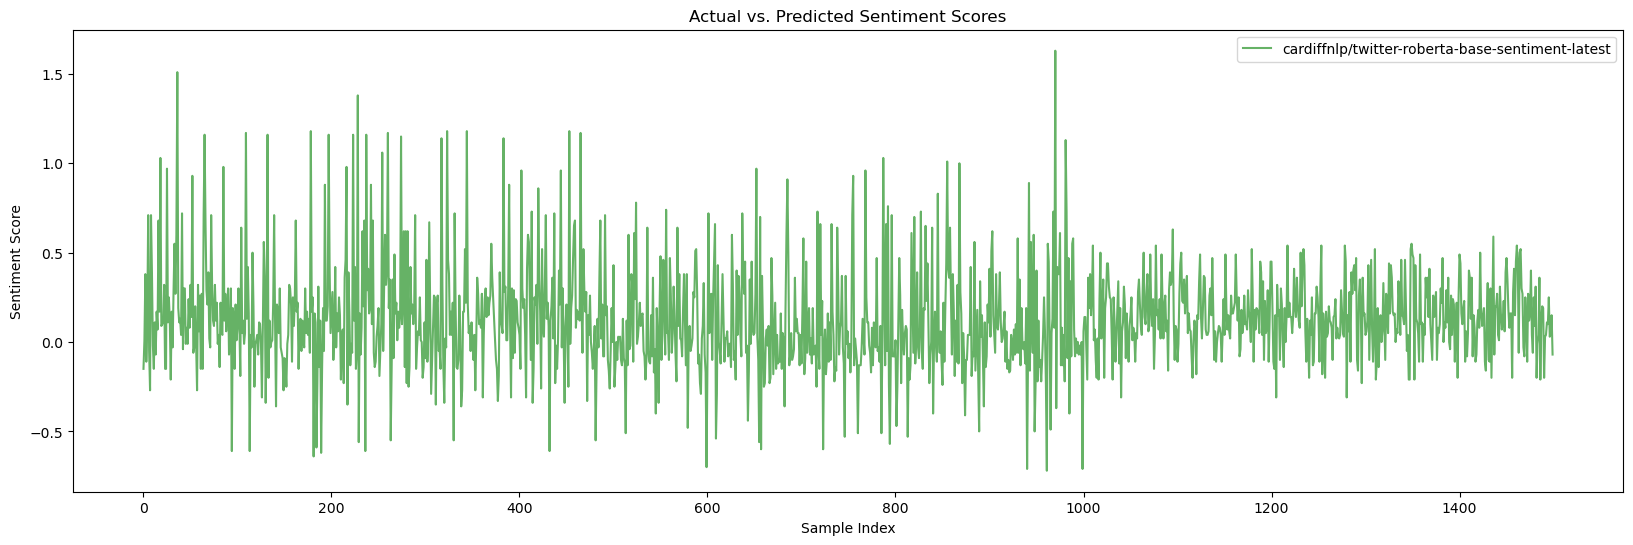

In [22]:
plt.figure(figsize=(20, 6))

# plt.plot(df.head(500)['sentiment_score_llama_3_8b'], color='black', label='Actual', alpha=0.6)
# plt.plot(df.head(500)['sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest'], color='blue', label='cardiffnlp/twitter-roberta-base-sentiment-latest', alpha=0.6)

plt.plot((df.head(1500)['sentiment_score_llama_3_8b']-df.head(1500)['sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest']), color='green', label='cardiffnlp/twitter-roberta-base-sentiment-latest', alpha=0.6)

# plt.plot((df.head(500)['sentiment_score_llama_3_8b']-df.head(500)['sentiment_score_finiteautomata/bertweet-base-sentiment-analysis']), color='blue', label='finiteautomata/bertweet-base-sentiment-analysis', alpha=0.6)

# plt.plot((df.head(500)['sentiment_score_llama_3_8b']-df.head(500)['sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis']), color='red', label='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()

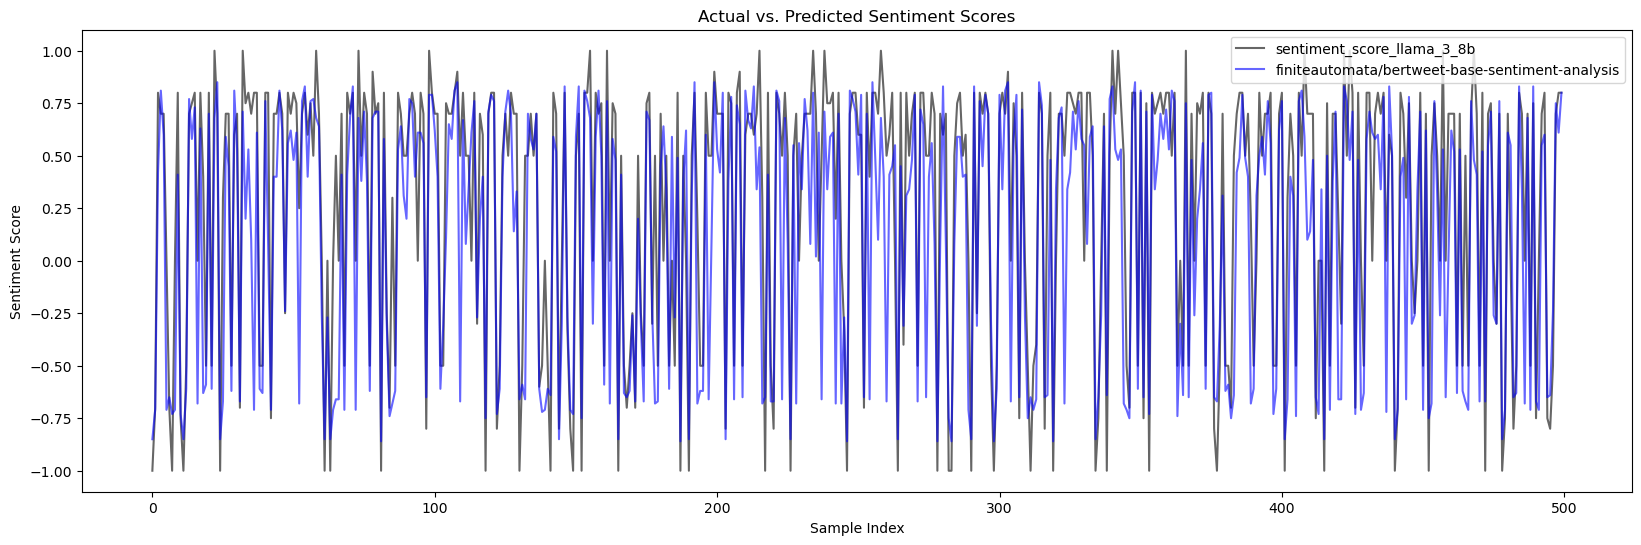

In [23]:
plt.figure(figsize=(20, 6))
plt.plot(df.head(500)['sentiment_score_llama_3_8b'], color='black', label='sentiment_score_llama_3_8b', alpha=0.6)
plt.plot(df.head(500)['sentiment_score_finiteautomata/bertweet-base-sentiment-analysis'], color='blue', label='finiteautomata/bertweet-base-sentiment-analysis', alpha=0.6)

# plt.plot((df.head(500)['sentiment_score_llama_3_8b']-df.head(500)['sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis']), color='red', label='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()

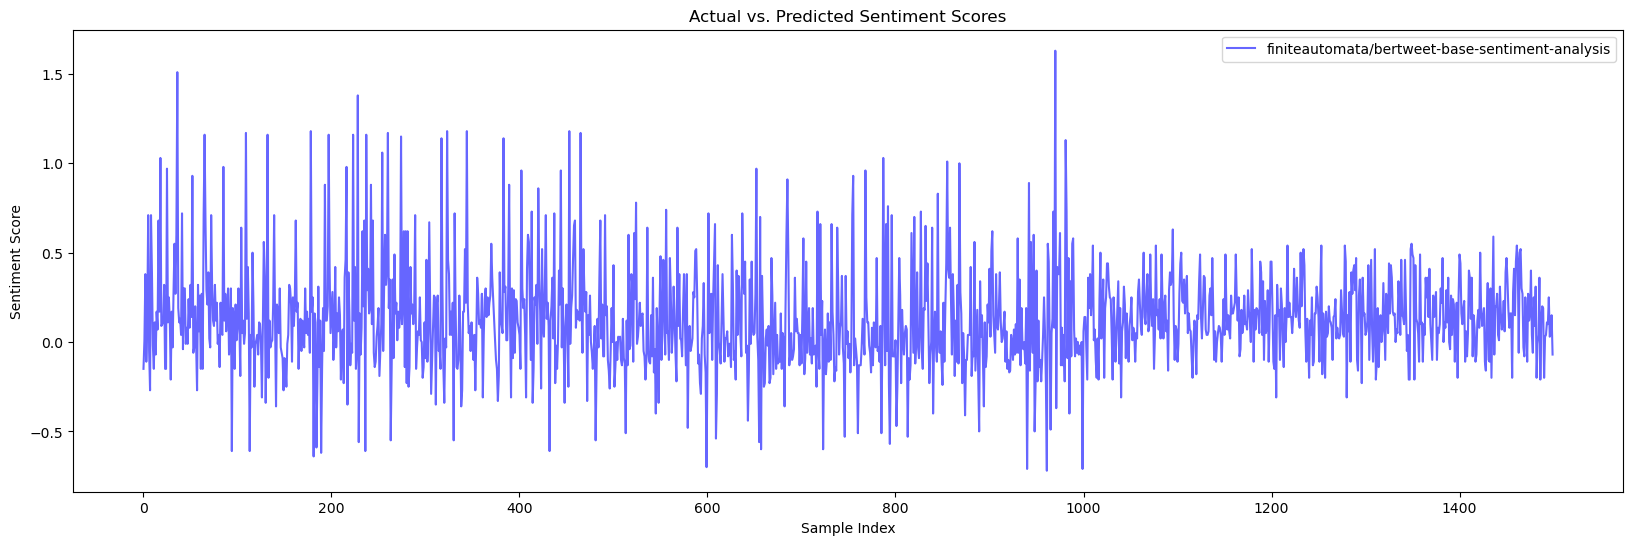

In [113]:
plt.figure(figsize=(20, 6))
plt.plot((df.head(1500)['sentiment_score_llama_3_8b']-df.head(1500)['sentiment_score_finiteautomata/bertweet-base-sentiment-analysis']), color='blue', label='finiteautomata/bertweet-base-sentiment-analysis', alpha=0.6)

# plt.plot((df.head(500)['sentiment_score_llama_3_8b']-df.head(500)['sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis']), color='red', label='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()

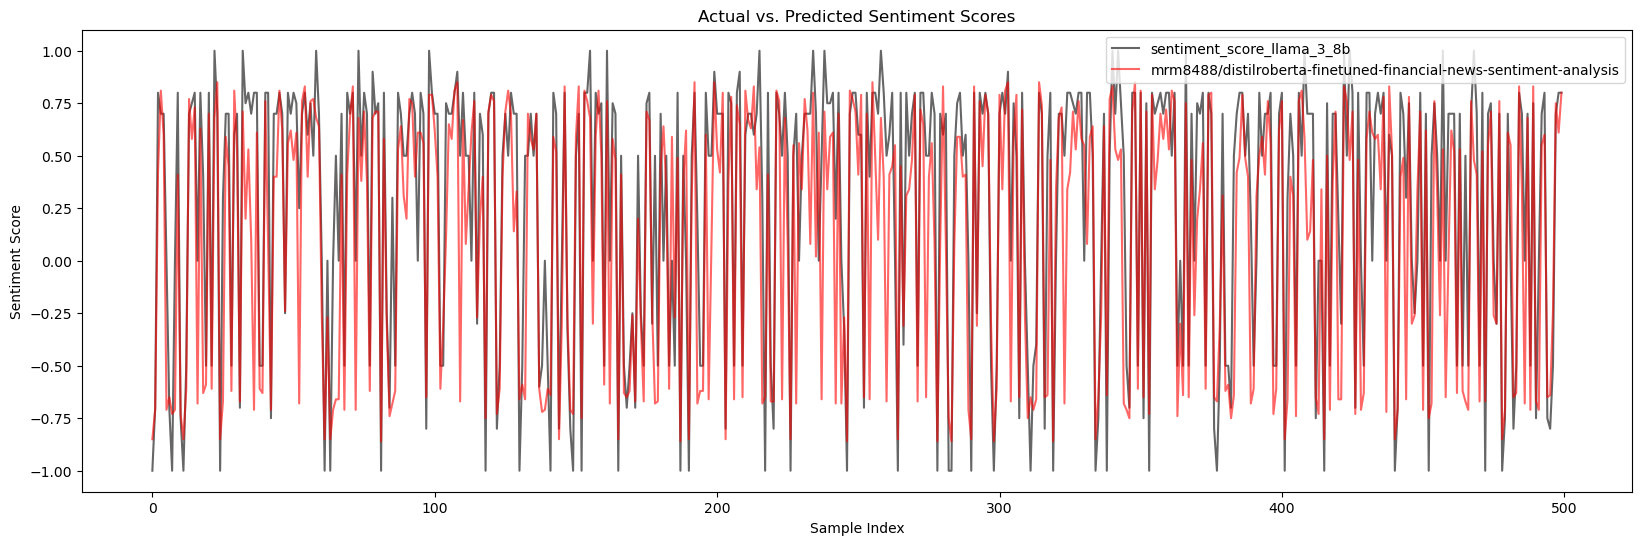

In [24]:
plt.figure(figsize=(20, 6))
plt.plot((df.head(500)['sentiment_score_llama_3_8b']), color='black', label='sentiment_score_llama_3_8b', alpha=0.6)
plt.plot((df.head(500)['sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis']), color='red', label='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()

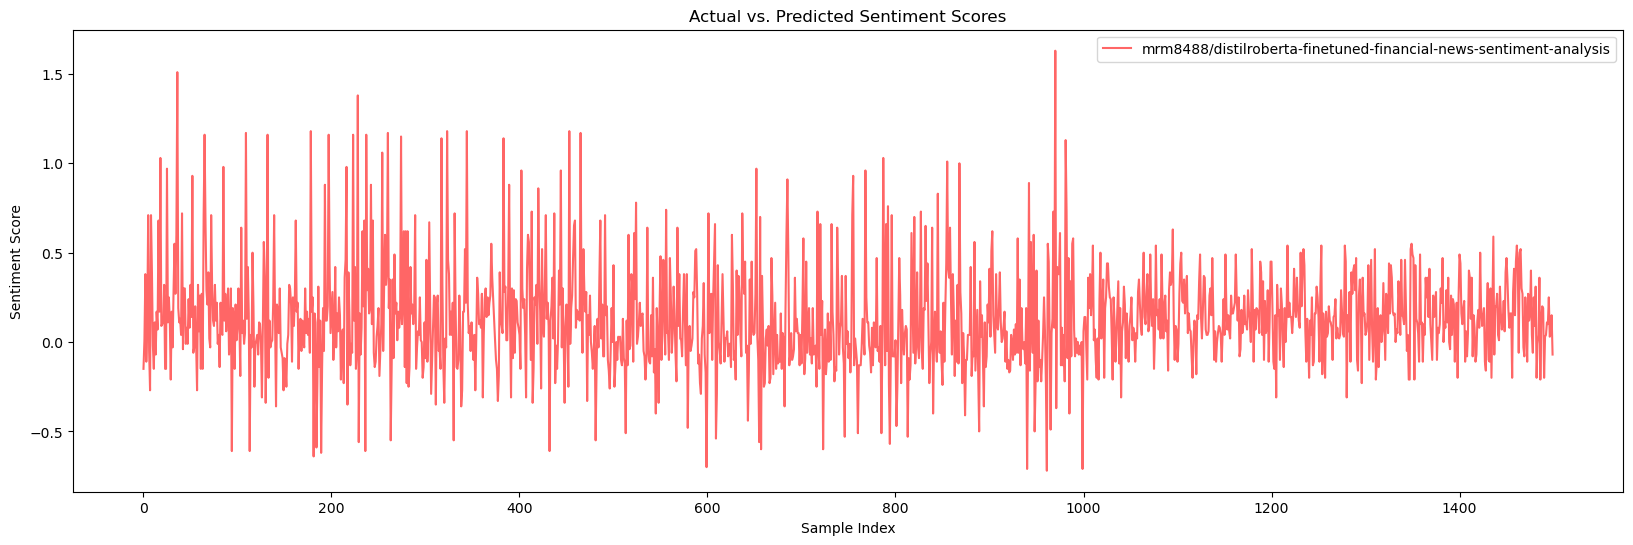

In [25]:
plt.figure(figsize=(20, 6))
plt.plot((df.head(1500)['sentiment_score_llama_3_8b']-df.head(1500)['sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis']), color='red', label='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()